In [1]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

import ray
from ray.rllib.algorithms.ppo import PPO
from ray.tune.logger import pretty_print

import symbtools as st
import sympy as sp
import pickle
import matplotlib.pyplot as plt

## Mathematical system description with SymPy / symbtools

In [2]:
# load model etc. from pickle of flatness analysis notebook
with open("double_crane_model.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [3]:
mod.xx

Matrix([
[   p1],
[   p2],
[   p3],
[   q1],
[   q2],
[pdot1],
[pdot2],
[pdot3],
[qdot1],
[qdot2]])

In [4]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[                                                                                                                                                                                                                  m2*pddot1 - tau3*(p1 - q1 - s2*cos(p3))/sqrt((p2 - s2*sin(p3))**2 + (p1 - q1 - s2*cos(p3))**2) - tau4*(-l0 + p1 - q2 + s2*cos(p3))/sqrt((p2 + s2*sin(p3))**2 + (-l0 + p1 - q2 + s2*cos(p3))**2)],
[                                                                                                                                                                                                                           g*m2 + m2*pddot2 - tau3*(p2 - s2*sin(p3))/sqrt((p2 - s2*sin(p3))**2 + (p1 - q1 - s2*cos(p3))**2) - tau4*(p2 + s2*sin(p3))/sqrt((p2 + s2*sin(p3))**2 + (-l0 + p1 - q2 + s2*cos(p3))**2)],
[J2*pddot3 + s2*tau3*(p2 - s2*sin(p3))*cos(p3)/sqrt((p2 - s2*sin(p3))**2 + (p1 - q1 - s2*cos(p3))**2) - s2*tau3*(p1 - q1 - s2*cos(p3))*sin(p3)/sqrt((p2 - s2*sin(p3))**2 + (p1 - q1 -

## Gym environment

In [5]:
from abc import abstractmethod
import inspect
import math
from typing import Optional, Union

import numpy as np
from scipy.integrate import solve_ivp

import gym
from gym import logger, spaces
#from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
#from gym.utils.renderer import Renderer

class StateSpaceModel(gym.Env):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        o
        o_
        oDim
    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=-1e4):
        self.tt = [0]
        self.dt = dt
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.uDim = uDim # inputs
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
            
        self.terminated = False
        self.terminal_cost = terminal_cost
    
    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u, self.dxdt), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        
        # todo: place difference for desired value with function or smth here
        self.o =  np.array(self.x, dtype=np.float32)
        reward = c
        return self.o, reward, self.terminated, {"info": False}
    
    @abstractmethod
    def terminate(self, *args):
        return



class GantryCraneEnv(StateSpaceModel):

    metadata = {}

    def __init__(self, cost, x0, dt, mod):
        super(GantryCraneEnv, self).__init__(self.ode, cost, x0, 4, dt)
        
        self.spec = gym.envs.registration.EnvSpec(id='GantryCraneEnv-v0', max_episode_steps=1000)
        
        F1, F2, F3, F4 = sp.symbols('F1 F2 F3 F4')

        params = sp.symbols('s2, m1, m2, m3, J2, l0, g')
        st.make_global(params)
        params_values = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items())
        
        states_dot = mod.f + mod.g * sp.Matrix([F1, F2, F3, F4]) ##:
        states_dot_wo_params = states_dot.subs(params_values)
        self.dxdt = st.expr_to_func([*mod.xx, F1, F2, F3, F4], states_dot_wo_params)

        # define observation space
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0,
                100.0,
                100.0, 
                100.0, 
                100.0, 
                100.0, 
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        # define action space
        high_act = np.array(
            [ 
                5.0,
                5.0,
                5.0,
                5.0
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
    
    def ode(self, t, x, u, dxdt):
        u1, u2, u3, u4 = u
        states_dot = dxdt(*x, u1, u2, u3 - 2.732085, u4 - 2.732085)
        return np.array(states_dot, dtype=np.float32)
    
    def terminate(self, x):
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = x
        if abs(x3) > 0.5 or abs(x4) > 10 or abs(x5) > 10:
            return True
        else:
            return False

## Cost function, Initial values

In [6]:
# TODO for reference learning look on:
# https://docs.ray.io/en/latest/rllib/rllib-offline.html
# https://docs.ray.io/en/latest/rllib/package_ref/offline.html

In [7]:
mod.xx.T

Matrix([[p1, p2, p3, q1, q2, pdot1, pdot2, pdot3, qdot1, qdot2]])

In [8]:
x_desired = [0.2, -0.2, 0.1, 0]

In [9]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = x
    xd1, xd2, xd3, xd4 = x_desired
    u1, u2, u3, u4 = u
    
    
    c = -50*(x1 - xd1)**2 -10*(x2 - xd2)**2 - 10*(x3 - xd3)**2 - 50*(x4 - xd4)**2 #- x10**2 
    
    if abs(x3 - xd3) < 0.02:
        c = c + 1
    
    if abs(x2 - xd2) < 0.02:
        c = c + 1

    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [
            1.49999995e-01 + np.random.uniform(-0.001,0.001), 
            -4.00000004e-01 + np.random.uniform(-0.001,0.001), 
             4.43002187e-08 + np.random.uniform(-0.001,0.001), 
            0.00000000e+00 + np.random.uniform(-0.001,0.001),
            0.00000000e+00 + np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001)
    ]
    return x0

t = 10 # time of an episode
dt = 0.01 # time step-size

learning_iterations = int(400) # define training iterations

## Create Gym env

In [10]:
# environment without renderings for training
env = GantryCraneEnv(c_k, p_x0, dt, mod)

In [11]:
env.reset()
env.step(env.action_space.sample())
env.observation_space

Box([-100. -100. -100. -100. -100. -100. -100. -100. -100. -100.], [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.], (10,), float32)

## Configure RL algo

In [13]:
ray.init()

2022-10-07 09:57:55,279	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.10.6
Ray version:,2.0.0


In [14]:
from ray.tune.registry import register_env

def env_creator(env_config):
    return GantryCraneEnv(**env_config) # return an env instanceregister_env("my_env", env_creator)

In [15]:
register_env("GantryCraneCustom", env_creator)

In [16]:
'''import ray
import ray.rllib.algorithms.ppo as ppo
from ray.tune.logger import pretty_print

config = ppo.DEFAULT_CONFIG.copy()
config["num_gpus"] = 0
config["num_workers"] = 1
algo = ppo.PPO(config=config, env="CartPole-v0")
'''

'import ray\nimport ray.rllib.algorithms.ppo as ppo\nfrom ray.tune.logger import pretty_print\n\nconfig = ppo.DEFAULT_CONFIG.copy()\nconfig["num_gpus"] = 0\nconfig["num_workers"] = 1\nalgo = ppo.PPO(config=config, env="CartPole-v0")\n'

In [17]:
#config

In [18]:
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "GantryCraneCustom",
    "env_config": {"cost":c_k, "x0":p_x0, "dt":dt, "mod":mod},
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 30,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        "fcnet_hiddens": [128, 128],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `algo.evaluate()` call after training (see below).
    "evaluation_num_workers": 1,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": False,
    },
}


## Training the model

In [19]:
agent = PPO(config=config)

2022-10-07 09:57:56,797	INFO algorithm.py:1871 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-10-07 09:57:56,798	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-10-07 09:57:56,798	WARNING ppo.py:350 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=30 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 134.
2022-10-07 09:57:56,798	INFO ppo.py:378 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setti

(RolloutWorker pid=4891) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4892) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4960) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4884) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4872) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4873) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4877) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4881) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4886) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4887) ]0;IPython: cluster/kwrede
(RolloutWorker pid=5074) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4940) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4889) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4893) ]0;IPython: cluster/kwrede
(RolloutWorker pid=5076) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4871) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4874) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4879) ]0;IPython: cluster/kwrede
(RolloutWorker pid=4880) ]0

2022-10-07 09:58:05,315	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-10-07 09:58:05,316	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-10-07 09:58:05,317	WARNING ppo.py:350 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=30 num_envs_per_worker=1 rollout_fragment_length=134)! Auto-adjusting `rollout_fragment_length` to 134.


(RolloutWorker pid=5853) ]0;IPython: cluster/kwrede


2022-10-07 09:58:10,613	INFO trainable.py:160 -- Trainable.setup took 13.826 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-10-07 09:58:10,614	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [20]:
for _ in range(learning_iterations):
    result = agent.train()

In [21]:
agent.evaluate()

{'evaluation': {'episode_reward_max': 18.381141943965297,
  'episode_reward_min': 17.23631939755584,
  'episode_reward_mean': 17.798012966202673,
  'episode_len_mean': 1000.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [17.86526963294382,
    18.381141943965297,
    17.833088508526846,
    17.23631939755584,
    17.813492358359554,
    17.62758218629901,
    18.13927642074967,
    18.257295032712207,
    17.53414969954397,
    17.29251448137055],
   'episode_lengths': [1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.2174213425825386,
   'mean_inference_ms': 0.6496768726752812,
   'mean_action_processing_ms': 0.0983529920018252,
   'mean_env_wait_ms': 2.3096105287389963,
   'mean_env_render_ms': 0.0},
  'num_faulty_episodes': 0,
  'num_agent

## Testing the model

In [22]:
u1_for_plots = []
u2_for_plots = []
u3_for_plots = []
u4_for_plots = []
x1_for_plots = []
x2_for_plots = []
x3_for_plots = []
x4_for_plots = []
x5_for_plots = []


obs = env.reset()
for i in range(1000):
    # inference smoothing!
    act_mean = [0, 0, 0, 0]
    for i in range(0, 4):
        action = agent.compute_action(obs)
        act_mean = act_mean + action
    action = act_mean/4
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action[0])
    u2_for_plots = np.append(u2_for_plots, action[1])
    u3_for_plots = np.append(u3_for_plots, action[2])
    u4_for_plots = np.append(u4_for_plots, action[3])
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    x3_for_plots = np.append(x3_for_plots, obs[2])
    x4_for_plots = np.append(x4_for_plots, obs[3])
    x5_for_plots = np.append(x5_for_plots, obs[4])
    if done:
      obs = env.reset()
      break;

2022-10-07 10:29:44,055	WARNING deprecation.py:47 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


## Steady state error

In [23]:
print("e1 =", x1_for_plots[-1] - x_desired[0])
print("e2 =", x2_for_plots[-2] - x_desired[1])
print("e3 =", x3_for_plots[-3] - x_desired[2])
print("e4 =", x4_for_plots[-4] - x_desired[3])

e1 = -0.0034679293632507435
e2 = 0.01500542163848878
e3 = -0.010080410540103918
e4 = -0.007000717334449291


## Plotting

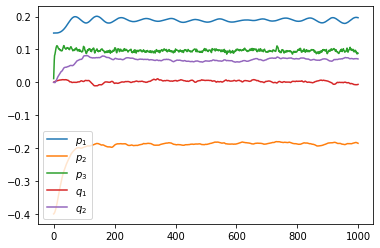

In [24]:
plt.plot(x1_for_plots, label=r"$p_1$")
plt.plot(x2_for_plots, label=r"$p_2$")
plt.plot(x3_for_plots, label=r"$p_3$")
plt.plot(x4_for_plots, label=r"$q_1$")
plt.plot(x5_for_plots, label=r"$q_2$")
plt.legend()

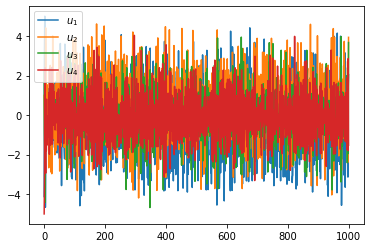

In [25]:
plt.plot(u1_for_plots, label=r"$u_1$")
plt.plot(u2_for_plots, label=r"$u_2$")
plt.plot(u3_for_plots, label=r"$u_3$")
plt.plot(u4_for_plots, label=r"$u_4$")
plt.legend()